# Magnetic Maps Inclination Prediction using convolutional neural networks (CNNs)

## Overview
The purpose of this Project is to train a CNN predictor that can predict inclinations of the magnetization of a source body in the subsurface, given a magnetic data map. 

During this project:
* understand the workflow of training a CNN.
* use Keras to train a CNN and make predictions.

## 0. What is inclination?

The Earth's magnetic field can be represented by a three-dimensional vector. A typical procedure for measuring its direction is to use a compass to determine the direction of magnetic North. Its angle relative to true North is the declination (D) or variation. Facing magnetic North, the angle the field makes with the horizontal is the inclination (I) or magnetic dip. The intensity (F) of the field is proportional to the force it exerts on a magnet.

<img src = "https://drive.google.com/uc?id=1-IJX4-gJRTmkxgP-diI5p0pndLIPJPf1" width = "600">


## 1. Import Packages

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation
from keras.utils import to_categorical

import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd

## 2. Load Data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving InclinationDictionary.npy to InclinationDictionary (1).npy
Saving obs_BlackHill2.mag to obs_BlackHill2 (1).mag
Saving XMagneticDataMaps.npy to XMagneticDataMaps (1).npy
Saving YMagneticDataMaps.npy to YMagneticDataMaps (1).npy


In [3]:
X = np.load("XMagneticDataMaps.npy","r")
Y = np.load("YMagneticDataMaps.npy", "r")

Note that **X** contains 4140 magnetic data maps, each of which is a 29 X 29 map. And **Y** contains 4140 labels, each of which corresponds to one data map in **X**.

**Note**: These training images were generated assuming the ambient inducing field is 50000 nT, and I=-65, D=8, susceptibility is 0.2, depth of the source body is 100m-200m. Also the angle increments for the forward-modeled datamaps were decreased from every 2 degrees to 4 degrees so that the data maps are not too large to be processed in Google Colab.

In [4]:
# Create a dictionary that connects each label to a unique inclination range
IncDict = np.load("InclinationDictionary.npy", "r")
Inc = {}
for i in range(len(IncDict)):
    Inc[IncDict[i,0]] = IncDict[i,1]

In [5]:
# conver integer category to inclination
def cat_to_inc(Y):
    return(Inc[str(int(Y))])

## 3. Data preprocessing

In [6]:
# Simple preprocessing 
# normalize each data type of the maximum value
X = X/np.max(X)

## 4. Visualize Data

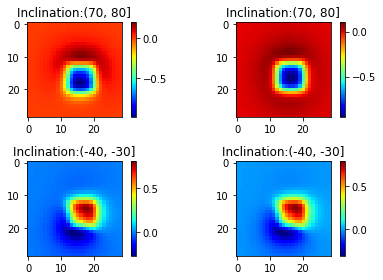

In [7]:
randnum = np.random.randint(0,4140,4)
for i in np.arange(4):
    plt.subplot(2,2,i+1)
    plt.imshow(X[randnum[i]].reshape((29,29)), cmap = 'jet')
    plt.colorbar()
    plt.title("Inclination:" + cat_to_inc(Y[randnum[i]]))
plt.tight_layout()      
plt.show()

You should notice that, the spatial patterns of the magnetic data anomalies depend upon the inclinations. In other words, there is a relationship between inclination (of magnetization) and spatial patterns (of magnetic anomalies shown in a data map). In this project, you are going to train a CNN to learn this relationship. Once the learning is finished, you will be able to predict the inclination, given a magnetic data map.

## 5. Prepare training, validation and test data

In [8]:
X_train = X[0:int(len(X)*0.6)]
X_val = X[int(len(X)*0.6):int(len(X)*0.6) + int(len(X)*0.2)]
X_test = X[int(len(X)*0.6) + int(len(X)*0.2): -1]

Y_train = to_categorical(Y[0:int(len(X)*0.6)])
Y_val = to_categorical(Y[int(len(X)*0.6):int(len(X)*0.6) + int(len(X)*0.2)])
Y_test = to_categorical(Y[int(len(X)*0.6) + int(len(X)*0.2): -1])

The <font color=red>**training data**</font> and the corresponding labels are, respectively, <font color=blue>**X_train**</font> and <font color=blue>**Y_train**</font>. <br>
The <font color=red>**validation data**</font> and the corresponding labels are, respectively, <font color=blue>**X_val**</font> and <font color=blue>**Y_val**</font>. <br>
The <font color=red>**test data**</font> and the corresponding labels are, respectively, <font color=blue>**X_test**</font> and <font color=blue>**Y_test**</font>.

## 6. Build and train your CNNs

<font color = red>**Task 1:**</font> Create and train a CNN. It is totally up to you to design this CNN. You should make sure that your CNN will result in training accuracy, validation accuracy and test accuracy whose difference is no larger than 4%.  

**Hint**: Because we are dealing with a multi-class problem here, you should use `softmax` as the activation for the output layer. And because there are 18 possible classes to predict, you should have 18 neurons in your last layer. 

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), strides=1, padding="same", input_shape=(29,29,1), activation="relu"))
# model.add(Conv2D(32, kernel_size=(3,3), strides=1, padding="same", input_shape=(29,29,1), activation="relu"))
#model.add(BatchNormalization()) # avoid the gradient vanish
# model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
# model.add(MaxPooling2D(pool_size=2)) # Reduce the dimension of figures
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(18, activation="softmax")) # Output layer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 29, 29, 32)        320       
                                                                 
 flatten (Flatten)           (None, 26912)             0         
                                                                 
 dense (Dense)               (None, 128)               3444864   
                                                                 
 dense_1 (Dense)             (None, 18)                2322      
                                                                 
Total params: 3,447,506
Trainable params: 3,447,506
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=10, verbose=1, validation_data=(X_test, Y_test))  # to learn more about fit, go to https://keras.rstudio.com/reference/fit.html

Epoch 1/10
20/20 [==============================] - 3s 106ms/step - loss: 2.0105 - accuracy: 0.3064 - val_loss: 1.4751 - val_accuracy: 0.4752
Epoch 2/10
20/20 [==============================] - 3s 133ms/step - loss: 1.2977 - accuracy: 0.4948 - val_loss: 1.1616 - val_accuracy: 0.4813
Epoch 3/10
20/20 [==============================] - 3s 132ms/step - loss: 0.9884 - accuracy: 0.6010 - val_loss: 0.9392 - val_accuracy: 0.6626
Epoch 4/10
20/20 [==============================] - 2s 94ms/step - loss: 0.7832 - accuracy: 0.7053 - val_loss: 0.7509 - val_accuracy: 0.6820
Epoch 5/10
20/20 [==============================] - 2s 97ms/step - loss: 0.6823 - accuracy: 0.7303 - val_loss: 0.6662 - val_accuracy: 0.6856
Epoch 6/10
20/20 [==============================] - 2s 104ms/step - loss: 0.5875 - accuracy: 0.7637 - val_loss: 0.5682 - val_accuracy: 0.7570
Epoch 7/10
20/20 [==============================] - 2s 104ms/step - loss: 0.5167 - accuracy: 0.7878 - val_loss: 0.5345 - val_accuracy: 0.7654
Epoch 8/

## 7. Check learning curves

<font color = red>**Task 2:**</font> Plot the learning curves (i.e., curves of the training loss, training accuracy, validation loss and validation accuracy). 

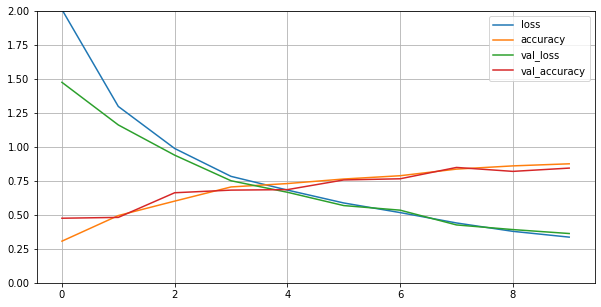

In [11]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

<font color = red>**Task 3:**</font> Describe the learning curves 


The accuracy and val_accuracy increase.

The loss and val_loss decrease.

The curves of training and validation data sets are pretty close, which represent our trained model is good, neither underfitting nor overfitting the data.

## 8. Check the accuracies on test data maps

<font color = red>**Task 4:**</font> Evaluate the model using test data. 

**HINT:** You can use `model.evaluate()`.

In [12]:
mse_test = model.evaluate(X_test,Y_test)

26/26 [==============================] - 0s 10ms/step - loss: 0.3626 - accuracy: 0.8440


## 9. Make predictions on synthetic test data maps

1/1 [==============================] - 0s 131ms/step


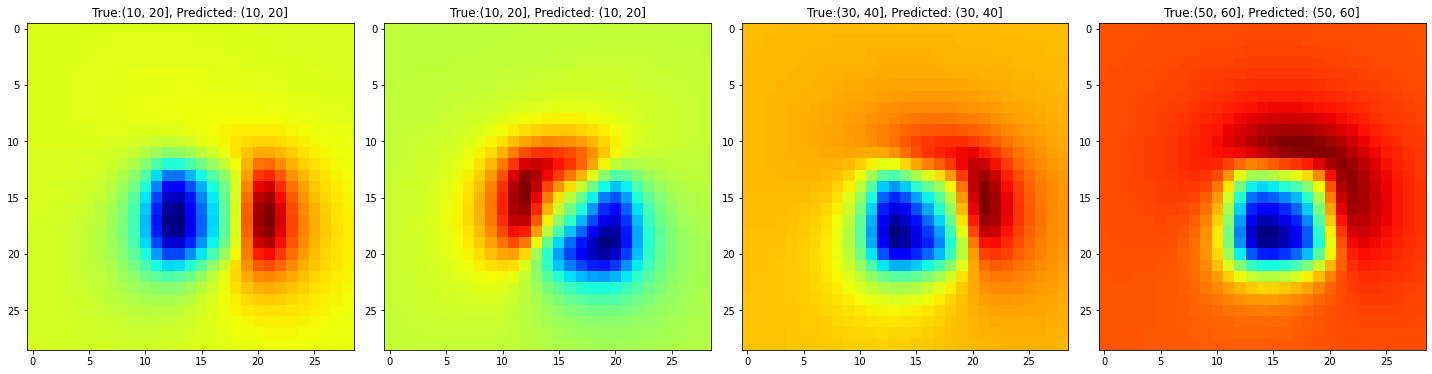

In [13]:
n = 420
Xpred = X_test[n:n+4]
Ytrue = Y_test[n:n+4]
Ypred = model.predict(Xpred)
plt.figure(figsize=(20,20))


for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(Xpred[i].reshape(29,29), cmap="jet")
    plt.title("True:" + cat_to_inc(np.argmax(Ytrue[i])) + ", Predicted: " + cat_to_inc(np.argmax(Ypred[i])))

plt.tight_layout()
plt.show()

<font color = red>**Task 5:**</font> Summarize your observations of the above predictions. 

We note that the figures from left to right are Fig. 1, Fig. 2, Fig. 3 and Fig. 4.

We firstly observe that different ranges of inclinations display the different patterns (e.g., Fig. 2, 3, and 4). 

We also notice the Fig. 1 and Fig. 2 possess different features though they have same range of inclination. This observation makes sense, because same inclination probably have different declinations.

## 10. Make predictions on field data

Let us apply the CNN that you trained above to field data!!! 

Our field data comes from an area in Australia called Black Hill Norite close to the City of Adelaide. Preivous studies show that these norites formed from a mafic intrusion of the Ordovician period.


Geoloy 101: Norite is a mafic intrusive igneous rock composed largely of the calcium-rich plagioclase labradorite, orthopyroxene, and olivine. The name norite is derived from Norge, the Norwegian name for Norway. Norite also known as orthopyroxene gabbro (https://en.wikipedia.org/wiki/Norite). Here is a picture of norite.

<img src = "https://drive.google.com/uc?id=1j_kpdMFM6BmmJQRzPPmOIsvpIGhY0kmJ" width = "300">

The magnetic data measured over this area is shown below (left). We observe strong magnetic anomalies resulting from the norite intrusions. In our project, we will focus on the anomalies located in the northwest region, which are shown below (right).

<img src = "https://drive.google.com/uc?id=1A8NmHyxM1CZ6acqhswX9cjfHo9EmCX5S" width = "500">

<img src = "https://drive.google.com/uc?id=1TJRzFz0Uv8yVLGfltkq6RZEd_ENgl3WJ" width = "500">


Your job now is to use the CNN predictor that you have already trained above and apply it to the magnetic anomalies shown above on the right to predict its inclination. 

### 10.1 Read the magnetic data 

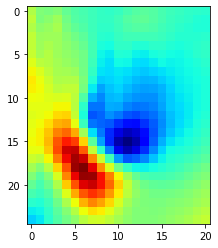

In [14]:
count = 0
i=0
data = np.zeros(int(21*25))
with open('obs_BlackHill2.mag') as f:
    for line in f:
        arr = line.split()
        if i> 1:
            data[count] = arr[3]
            count+=1
        i+=1
data2d = np.reshape(data,(25,21))
plt.imshow(data2d,cmap='jet')

data2d_normalize = np.reshape(data2d, (1,25,21,1))/np.max(data2d)


### 10.2 Make prediction

In [15]:
field_data_resized = tf.image.resize(data2d_normalize,[29,29])

<font color = red>**Task 6:**</font> Apply the CNN that you trained above to the field data `field_data_resized`. Assign your prediction to `y_pred`.

In [16]:
y_pred = model.predict(field_data_resized)
print(y_pred)

1/1 [==============================] - 0s 25ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  2.6282044e-26 3.3657410e-14 1.0277860e-14 7.3759342e-03 9.9262094e-01
  3.1335805e-06 6.0489177e-14 3.6818825e-12 2.0264923e-26 6.8595392e-33
  1.5746789e-27 3.6659134e-38 0.0000000e+00]]


In [17]:
print('The predicted inclination is:',cat_to_inc(np.argmax(y_pred)))

The predicted inclination is: (0, 10]


## Acknowledgments
I would like to thank Felicia Nurindrawati for help create this lab exercise. Felicia was a graduate student working with Dr. Jiajia Sun in the Department of Earth and Atmospheric Sciences at the University of Houston. She is now a machine learning engineer at TCarta. <br>

<img src = "https://drive.google.com/uc?id=1C8058sZbGd3IDZg1lHi6wHklflysMALe" width = "200">
